## Original data

###**Load the data**

In [ ]:
# Read raw dataset
import pandas as pd

# Customer
df_demographic = pd.read_csv(r'/content/drive/MyDrive/Dataset/BI9_competition/Bản sao của SA#var.csv', sep=';')
df_demographic.drop(columns = 'Col', inplace=True)
df_segmentation = pd.read_csv(r'/content/drive/MyDrive/Dataset/BI9_competition/Bản sao của 2017Segmentation3685case.csv', sep=';')
df_companion = pd.read_csv(r'/content/drive/MyDrive/Dataset/BI9_competition/Bản sao của Companion.csv', sep=';')
df_day = pd.read_csv(r'/content/drive/MyDrive/Dataset/BI9_competition/Bản sao của Dayofweek.csv', sep=';')
df_daypart = pd.read_csv(r'/content/drive/MyDrive/Dataset/BI9_competition/Bản sao của Daypart.csv', sep = ';')
df_need = pd.read_csv(r'/content/drive/MyDrive/Dataset/BI9_competition/Bản sao của NeedstateDayDaypart.csv', sep=';')

# Brand
df_bhealth = pd.read_csv(r'/content/drive/MyDrive/Dataset/BI9_competition/Bản sao của Brandhealth.csv', sep=';', low_memory=False)
df_bimage = pd.read_csv(r'/content/drive/MyDrive/Dataset/BI9_competition/Bản sao của Brand_Image.csv', sep=';')

# Competitor
df_compete = pd.read_csv(r'/content/drive/MyDrive/Dataset/BI9_competition/Bản sao của Competitor database_xlnm#_FilterDatabase.csv', sep=';')

### df_companion

In [ ]:
# drop duplication
df_companion.drop_duplicates(inplace=True)

### df_day

In [ ]:
# df_day has ~54 nulls -> 0.01% of data -> drop
df_day.dropna(inplace=True)
# drop duplicated rows
df_day.drop_duplicates(inplace=True)

### df_daypart

Fill missing data for df_daypart for respondents interviewed more than once by:

- Use median to estimate their Visit#Daypart in different interviews
- Then drop cols that cannot be filled (due to the uniqueness of ID, we have no proof to make estimation)

In [ ]:
# Fill then drop for df_daypart
# Assumption: People behavior will not suddenly change in short time (2017 - 2019)
#             Therefore one ID will have same Visit#Daypart all along the data
for i, v in enumerate(df_daypart['ID'].unique()):
    sub_df = df_daypart[df_daypart['ID'] == v]
    med_vals = sub_df['Visit#Daypart'].median()
    if len(sub_df) <= 1:
        continue
    else:
      df_daypart.loc[(df_daypart['ID'] == v) & (df_daypart['Visit#Daypart'].isnull()), 'Visit#Daypart'] = round(med_vals,0)
# Drop the rest which can't be filled (due to small number)
df_daypart.dropna(inplace=True)

### df_need

In [ ]:
# drop duplicated rows
df_need.drop_duplicates(inplace=True)

### df_bhealth

In [ ]:
# drop redudndant col
df_bhealth.drop(columns = 'Spending_use', inplace=True)

In [ ]:
# We will assume Awareness = Spontaneous for ease of analysis further in question 4 and 5
# First Fill Awareness with Spontaneous
df_bhealth.loc[df_bhealth['Awareness'].isna(), 'Awareness'] = df_bhealth['Spontaneous']

# Then delete all nulls
# Because in ques 4 we are required to analyze process from Awareness -> Loyalty -> without Awarenes/Spontaneous this can't be done
# And the number of null is small
df_bhealth.dropna(subset='Awareness', inplace=True)

# Finally drop Spontaneous column
df_bhealth.drop(columns='Spontaneous', inplace=True)

Since the table looks like a funnel in stage Aware - > Trial.
- We assume where Trial is null, Trial can be filled as None, representing consumers stop moving on with the brand
- However, if they either P3M, P1M, weekly, daily visit the brand or comprehend it (!= don't understand it at all or maybe don't understand) =>> they must have Tried the brand

In [ ]:
condition = (
    df_bhealth['P3M'].notna() |
    df_bhealth['P1M'].notna() |
    df_bhealth['Comprehension'].notna() &
    df_bhealth['Comprehension'].isin(['Maybe do not know it', 'Do not know it at all']) |
    df_bhealth['Weekly'].notna() |
    df_bhealth['Daily'].notna()
)

df_bhealth.loc[df_bhealth['Trial'].isna() & condition, 'Trial'] = df_bhealth['Awareness']
df_bhealth.loc[df_bhealth['Trial'].isna(), 'Trial'] = 'None'


NPS is the likelihood of someone recommending the brand:
- So we will fill NaN rows with values in rows of similar ID and Year
- This means people's NPS is same in one year but can change throughout time
- We assume NPS has nothing to do with the brand but rather the personality of the customer

In [ ]:
# NPS#P3M
df_bhealth['NPS#P3M'] = df_bhealth.groupby(['ID', 'Year'])['NPS#P3M'].transform(lambda x: x.ffill().bfill())

In [ ]:
# Fill NPS Group (No score for people not having NPS data)
df_bhealth['NPS#P3M#Group'] = df_bhealth['NPS#P3M']. \
                              apply(lambda x:
                                    'Detractor' if x >= 0 and x <=6 else
                                    'Passiver' if x >=7 and x <=8 else
                                    'Promoter' if x >=9 and x <=10 else
                                    'None type')

Apply the same rule for other column:
- Same ID -> same values
- Because everyone is interviewed once, and that a person visits one brand does not mean he/she also visits the other brand
- We decided to fill P1M and P3M "None at all" where null
- Same for Daily and Weekly

In [ ]:
# P1M and P3M
df_bhealth.loc[df_bhealth['P3M'].isna(), 'P3M'] = 'None at all'
df_bhealth.loc[df_bhealth['P1M'].isna(), 'P1M'] = 'None at all'

# Comprehend
# As we have no clue if the customers comprehend the brand or not, we'll rename as "Unanswered"
df_bhealth.loc[df_bhealth['Comprehension'].isna(), 'Comprehension'] = 'Unanswered'

# Brand_likability
# The definition in dict is not same as its content -> drop
df_bhealth.drop(columns = 'Brand_Likability', inplace=True)

# Weekly
df_bhealth.loc[df_bhealth['Weekly'].isna(), 'Weekly'] = 'Not Applicable'
# Daily
df_bhealth.loc[df_bhealth['Daily'].isna(), 'Daily'] = 'Not Applicable'

For PPA, Spending, and Visit:
- We have data in year 2017 located in Segmentation table
- We can fill data relying on data in 2017Segmentation

In [ ]:
# PPA
# we group by ID and used median as final value to avoid distorted result due to outliers
df_seg = df_segmentation.groupby('ID').agg(
    PPA = ('PPA', 'median'),
    Spending = ('Spending', 'median'),
    Visit = ('Visit', 'median')
).reset_index()

df_bh = df_bhealth.merge(
    df_seg[['ID','PPA']],
    on= 'ID',
    how='left',
    suffixes=('', '_from_seg')
)

df_bhealth['PPA'] = df_bhealth['PPA'].combine_first(df_bh['PPA_from_seg'])

In [ ]:
# Spending
# Same process
df_bk = df_bhealth.merge(
    df_seg[['ID', 'Spending']],
    on= ['ID'],
    how='left',
    suffixes=('', '_from_seg')
)

df_bhealth['Spending'] = df_bhealth['Spending'].combine_first(df_bk['Spending_from_seg'])

In [ ]:
# Fre#Visit
# Same process
df_bz = df_bhealth.merge(
    df_seg[['ID', 'Visit']],
    on= ['ID'],
    how='left'
)

df_bhealth['Fre#visit'] = df_bhealth['Fre#visit'].combine_first(df_bz['Visit'])

In [ ]:
# Fill in segmentation
df_bhealth.loc[df_bhealth['PPA']<25, 'Segmentation'] = 'Seg.01 - Mass (<VND 25K)'
df_bhealth.loc[(df_bhealth['PPA']>=25) & (df_bhealth['PPA']<60), 'Segmentation'] = 'Seg.02 - Mass Asp (VND 25K - VND 59K)'
df_bhealth.loc[(df_bhealth['PPA']>=60) & (df_bhealth['PPA']<100), 'Segmentation'] = 'Seg.03 - Premium (VND 60K - VND 99K)'
df_bhealth.loc[df_bhealth['PPA']>=100, 'Segmentation'] = 'Seg.04 - Super Premium (VND 100K+)'
df_bhealth.loc[df_bhealth['PPA'].isna() == True, 'Segmentation'] = 'Unindentified'


Since we have no clue to fill PPA, Spending, Visit that are still null:
- The data may be in year 2018 2019 -> no table usable to fill
- The data could be in 2017 but not to be found outside bhealth table

We decided to keep the null as they are for the integrity of data to be remained

Finally, Standardize formatting: Other 1, Other 2, ... ->> Other

In [ ]:
import re
for col in ['Brand', 'Awareness', 'Trial', 'P3M', 'P1M', 'Comprehension', 'Weekly', 'Daily']:
  df_bhealth[col] = df_bhealth[col].\
                    apply(
                        lambda text: re.sub(r'^Other.*$', 'Other Brand', text)
)
  df_bhealth[col] = df_bhealth[col].\
                    apply(
                        lambda text:
                        re.sub(r'^Street.*$', 'Street/Half street coffee', text))

# Drop duplicates that has been born
# We need to delete them
df_bhealth.drop_duplicates(inplace=True)

### df_bimage

Standardize the name of column BrandImage

In [ ]:
import re
for col in df_bimage.select_dtypes('object').columns:
  df_bimage[col] = df_bimage[col].\
                    apply(
                        lambda text:
                        re.sub(r'^Other.*$', 'Other Brand',
                        str(text)))
  df_bimage[col] = df_bimage[col].\
                    apply(
                        lambda text:
                        re.sub(r'^Street.*$', 'Street/Half street coffee',
                        str(text)))

Awareness should be dropped:
- It's a duplication of BrandImage (except for location = NaN)
- It does not have as much data as BrandImage

In [ ]:
df_bimage.drop(columns='Awareness', inplace=True)

Drop dupliacted rows

In [ ]:
# drop duplicated rows
df_bimage.drop_duplicates(inplace=True)

### df_compte

In [ ]:
# column No# is redun
df_compete.drop(columns = 'No#', inplace =True)

### df_demographic

In [ ]:
# drop the duplicated cols
# MPI#Mean == MPI_Mean_Use
df_demographic.drop(columns = 'MPI#Mean', inplace=True)
# df_demographic table
df_demographic.drop(columns = ['MPI#2'], inplace=True)

In [ ]:
# dropna demographic with cols with little nulls (under 20 nulls in total)
df_demographic.dropna(subset=['Age', 'Group_size'], inplace=True)

We assume those saying nothing as Having no preferred brand before:
- Because BUMO is fullly filled
- Therefore, this means there should be no one refusing to respond to such type of question (about BUMO)
- The only logical intepretation is they did not have previous BUMO

In [ ]:
# df_demographic BUMO
df_demographic.fillna({'BUMO_Previous':"Don't have any brands"}, inplace=True)

Next for MPI_Mean_use:
- we see the volume of nulls are 30% -> drop is not suitable
- we will fill based on Occupation#group
- Our assumption is that people of same Occupation will have similar range of income
- So we'll fill the median based on Occupation:
  + median is better than mean for it avoids outlier better
  + median better than mode because mode can go wrong if there is no values dominating in number

In [ ]:
# Fill NA for MPI_Mean_Use
for i, v in enumerate(df_demographic['Occupation'].unique()):
    sub_df = df_demographic[df_demographic['Occupation'] == v]
    med_vals = sub_df['MPI_Mean_Use'].median()
    if len(sub_df) <= 1:
        continue
    else:
      df_demographic.loc[(df_demographic['Occupation'] == v) & (df_demographic['MPI_Mean_Use'].isnull()), 'MPI_Mean_Use'] = med_vals

In [ ]:
# Now as MPI_Mean_Use nulls left are 13 only -> drop
df_demographic.dropna(subset='MPI_Mean_Use',inplace=True)

We discover that:
- 'Self Employed \xa0- Company owner (under 10 employees)' == 'Business Owner with less than 10 employees'
- They also in the same occupation group

In [ ]:
df_demographic['Occupation'] = df_demographic['Occupation'].replace(
   {'Business Owner with less than 10 employees':
    'Self Employed \xa0- Company owner (under 10 employees)'})

- Lastly for MPI#detail and MPI we can use the data from MPI_Mean_Use to help fill in accordingly

- Admitedlly, by doing this, we mistakenly assign a range to the "refuse"
- But as we assume: people of same Occupation will have same range
- And the number of mislabelled Refuse is only 32 -> very small and negligible
- =>>> filling is acceptable

In [ ]:
# Fill MPI#detail
bins = [0, 2990, 4490, 6490, 7490, 8990, 11990, 14990, 19990, 24990, 29990, 44990, 74990, 149990]
labels = [
    'Under 3 millions VND',
    'From 3 millions to 4.49 millions VND',
    'From 4.5 millions to 6.49 millions VND',
    'From 6.5 millions to 7.49 millions VND',
    'From 7.5 millions to 8.99 millions VND',
    'From 9 millions to 11.99 millions VND',
    'From 12 millions to 14.99 millions VND',
    'From 15 millions to 19.99 millions VND',
    'From 20 millions to 24.99 millions VND',
    'From 25 millions to 29.99 millions VND',
    'From 30 millions to 44.99 millions VND',
    'From 45 millions to 74.99 millions VND',
    'From 75 million to VND 149.99 million VND'
]

df_demographic['MPI#detail'] = pd.cut(df_demographic['MPI_Mean_Use'], bins=bins, labels=labels, right=True)

In [ ]:
# Fill MPI
import numpy as np
bins = [0, 4500, 8900, 14900, 24900, np.inf]
labels = [
    'Under VND 4.5m',
    'VND 4.5m - VND 8.9m',
    'VND 9m - VND 14.9m',
    'VND 15m - VND 24.9m',
    'VND 25m+'
]
# Apply pd.cut
df_demographic['MPI'] = pd.cut(df_demographic['MPI_Mean_Use'], bins=bins, labels=labels, right=True)


Reformating label

In [ ]:
# reformat MPI detail
def reformat_mpi_detail(text):
  pattern1 = r'From (\d+(?:\.\d+)?) millions to (\d+(?:\.\d+)?) millions VND'
  pattern2 = r'From (\d+(?:\.\d+)?) million to VND (\d+(?:\.\d+)?) million VND'
  pattern3 = r'Under (\d+(?:\.\d+)?) millions VND'

  replacement = r'VND \1m - VND \2m'
  repl_under = r'Under VND \1m'

  import re
  if re.search(pattern1, text):
      return re.sub(pattern1, replacement, text)
  elif re.search(pattern2, text):
      return re.sub(pattern2, replacement, text)
  elif re.search(pattern3, text):
      return re.sub(pattern3, repl_under, text)
  else:
      return text  # Leave unchanged if no match

df_demographic['MPI#detail'] = df_demographic['MPI#detail'].apply(lambda text: reformat_mpi_detail(text))

In [ ]:
# reformat age group
import re
df_demographic['Age#Group#2']=df_demographic['Age#Group#2'].apply(
    lambda age:
    re.sub(r'(\d+\s*-\s*\d+|\d+\+)\s*y\.o\.', r'\1', age)
)

In [ ]:
# reformat Other,Other 1, ... =>> Other Brand
for col in ['TOM', 'BUMO', 'BUMO_Previous',
            'MostFavourite', ]:
  df_demographic[col] = df_demographic[col].\
                    apply(
                        lambda text:
                        re.sub(r'^Other.*$', 'Other Brand',
                        text))
  df_demographic[col] = df_demographic[col].\
                    apply(
                        lambda text:
                        re.sub(r'^Street.*$', 'Street/Half street coffee',
                        text))

## Data preparation for training

We will prepare the suggested data, grouping them into one table in
 preparation for clustering process

Since we are dealing with Highland Coffee, we will limit the dataset to Highland coffee only

To carry out clustering and segmentation, we need to compile a clean dataset, here are some criteria we based on to construct such table:
- the table should holistically describe our customers' persona:
  + Demographic: Age, MPI_Mean_use, Occupation group
  + Psychology (need): Needstate#group
  + Perception: NPS#P3M, Comprehension
  + Behavior: Fre#Visit, PPA, Spending, Companion

- the columns list above ensure that the data is holistic, covering all possible types of customers visiting Highlands, while also reducing the complexity of the data.
- For example, instead of using Occupation, we use Occupation#Group. The latter contains fewer but still holistic items.
- Also, this reduced complexity helps fasten the model without sacrificing accuracy.

Next we will transform the data:
- Delete NaN:
  + we have tested with filling using median, KNN imputation (we have shortened our work by not including median and KNN imputation fill in this work)
  + and the result returns unfavorable cluster. So we decided to **drop all nulls**
- We also check for outliers to delete promptly outlying values that could weaken prediction ability of our model
- We do one-hot encoding to turn category into calculable numeric form.

In [ ]:
# Limit brand health survey to "Highland Coffee"
# We choose bhealth because this has the most thorough list of ID
# Also, bhealth has column Brand, making filtering easy

# unique ID
bhealth_highland = df_bhealth[df_bhealth['Brand']=='Highlands Coffee']
bhealth_highland = bhealth_highland[['ID',
                                    'Comprehension',
                                     'Fre#visit',
                                     'Spending',
                                     'PPA',
                                     'NPS#P3M']]
# Limit the other required tables
a = bhealth_highland['ID'].unique()

# transform the other required table

# Non_unique ID
companion_highland = df_companion[df_companion['ID'].isin(a)]
companion_highland = companion_highland[['ID',
                                         'Companion#group']]

# Non_unique ID
need_highland = df_need[df_need['ID'].isin(a)]
need_highland = need_highland[['ID',
                               'NeedstateGroup']]

# Unique ID
demo_highland = df_demographic[df_demographic['ID'].isin(a)]
demo_highland = demo_highland[['ID',
                               'Age',
                               'MPI_Mean_Use',
                               'Occupation#group']]

We carry out one-hot encoding before dealing with NaN

- One hot encoding for Non_unique Ids

In [ ]:
# Companion
companion_highland = pd.get_dummies(companion_highland, columns=['Companion#group'], dtype=int)
companion_highland = companion_highland.groupby('ID').max().reset_index()

# Needstate
need_highland = pd.get_dummies(need_highland, columns=['NeedstateGroup'], dtype=int)
need_highland = need_highland.groupby('ID').max().reset_index()

- One hot encoding for tables with Unique IDs

In [ ]:
# Preprocessing for bhealth

# For comprehension we would change "Unanswered", "Maybe do not know it", and "Do not know it at all"
# as "Do not know it"
# Because:
# We are conservative in our prediction, so we assume Unanswered as Do not know about it. This conservatism helps Highland to be cautious in business
# Also, standardize "do not know it" can simplify the model as "Maybe do not know it", and "Do not know it at all" both reflects ignorance.

bhealth_highland['Comprehension'] = bhealth_highland['Comprehension'].apply(
                                    lambda x: 'Do not know it'
                                    if x in ['Unanswered', 'Maybe do not know it', 'Do not know it at all']
                                    else x)


In [ ]:
# bhealth
bhealth_highland = pd.get_dummies(bhealth_highland,
                                  columns=['Comprehension'],
                                  dtype=int)


# demographic
demo_highland = pd.get_dummies(demo_highland,
                               columns=['Occupation#group'],
                               dtype=int)

Merge all tables into 1

In [ ]:
# Merging on ID using left join
df_master = demo_highland.merge(bhealth_highland, on='ID', how='left')
df_master = df_master.merge(companion_highland, on='ID', how='left')
df_master = df_master.merge(need_highland, on='ID', how='left')

In [ ]:
# Make sure PPA = Spend/Visit
df_master['PPA'] = df_master['Spending']/df_master['Fre#visit']

Drop all other missing values due to small number

In [ ]:
df_master.dropna(inplace=True)

Outlier

<Axes: xlabel='Spending', ylabel='MPI_Mean_Use'>

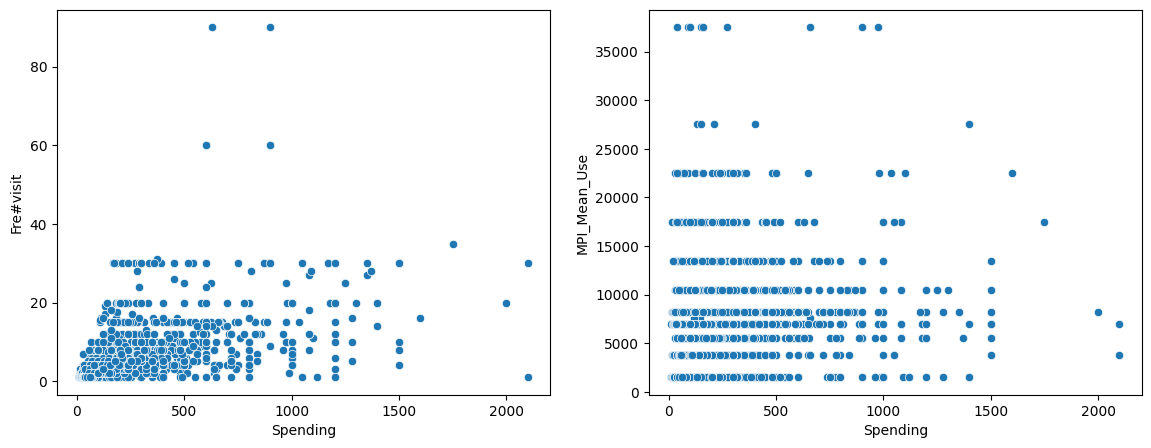

In [ ]:
# Check outlier for MPI_Mean_Use and Spending
import seaborn as sns
import matplotlib.pyplot as plt
fig, axe = plt.subplots(1, 2, figsize=(14, 5))
sns.scatterplot(data = df_master, x = 'Spending', y = 'Fre#visit', ax = axe[0])
sns.scatterplot(data = df_master, x = 'Spending', y = 'MPI_Mean_Use', ax = axe[1])

In [ ]:
# Drop outlier
df_master = df_master[(df_master['Spending'] < 1510) &
                      (df_master['MPI_Mean_Use'] < 40000) &
                      (df_master['Fre#visit'] < 40)]